# Anomaly Detection using Auto-Encoder

"Autoencoder" is a neural-net based dimensionality reduction method. The method learns a low-dimensional representation of data by learning to approximate the identity function using a deep network that has an information bottleneck.

The autoencoder network is made of an encoder net and a decoder net. The encoder net transforms the input data into a low-dimensional numeric representation (also called latent representation). The decoder attempts to reconstruct the original input from the latent representation:

The encoder and decoder networks are trained together by minimizing the discrepancy between the original data and its reconstruction.

The reconstruction error can be used to detect anomalies in the data. Here we build and train a shallow LSTM autoencoder using the Keras API and experiment with a stock market time series to find anomalies by pre defined threshold

In [32]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [486]:
# Getting historical data for Dow Jones Industrial Average index

ticker = 'SPY'
ticker = 'DJI'

sdate = '1990-01-01'
edate = '2018-01-01'

data = yf.download(ticker, sdate, edate)

[*********************100%***********************]  1 of 1 completed


In [487]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,2810.149902,2810.149902,2810.149902,2810.149902,2810.149902,0
1990-01-03,2809.729980,2809.729980,2809.729980,2809.729980,2809.729980,0
1990-01-04,2796.080078,2796.080078,2796.080078,2796.080078,2796.080078,0
1990-01-05,2773.250000,2773.250000,2773.250000,2773.250000,2773.250000,0
1990-01-08,2794.370117,2794.370117,2794.370117,2794.370117,2794.370117,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f16c207efa0>,
      dtype=object)

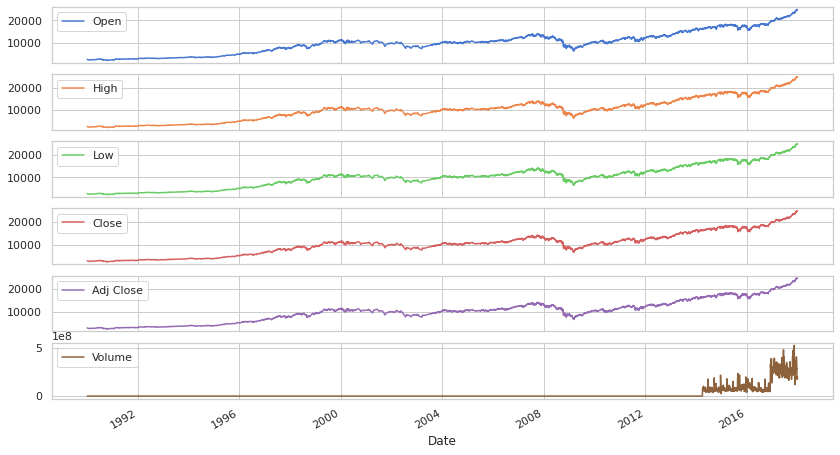

In [488]:
data.plot(subplots = True)

## Visualize the time series

In [489]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = data.index, y = data.Close, mode = 'lines', name = 'Close'))
fig.update_layout(showlegend = True)
fig.show()

## Preparing the data, train-test split and scaling

In [490]:
def prep_train_test(data):
    m = data.shape[0]
    train_size = int(m*.8)
    test_size = m - train_size
    return data.iloc[:train_size], data.iloc[train_size:]

In [491]:
scaler = StandardScaler()
data[["Close_scaled"]] = scaler.fit_transform(data[["Close"]])
train, test  = prep_train_test(data)

In [492]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,Close_scaled
Date,,,,,,,
2013-08-05,15612.099609,15612.099609,15612.099609,15612.099609,15612.099609,0,0.990683
2013-08-06,15518.700195,15518.700195,15518.700195,15518.700195,15518.700195,0,0.973118
2013-08-08,15498.299805,15498.299805,15498.299805,15498.299805,15498.299805,0,0.969282
2013-08-09,15425.500000,15425.500000,15425.500000,15425.500000,15425.500000,0,0.955591
2013-08-12,15419.700195,15419.700195,15419.700195,15419.700195,15419.700195,0,0.954501


In [493]:
def make_seq(df, col, window = 32):
    x_s , y_s = [], []
    m = df.shape[0]
    for i in range(df.shape[0]-window):
        x_s.append(df[col][i:(i+window)])
        y_s.append([df[col][(i+window)]])
    return np.array(x_s)[:, :, np.newaxis], np.array(y_s)

In [494]:
window = 32
x_train, y_train = make_seq(train, 'Close_scaled', window)
x_test, y_test = make_seq(test, 'Close_scaled', window)

In [495]:
x_train.shape

(4349, 32, 1)

## Build the AutoEncoder

In [496]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Lambda, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 

class Autoencoder():
    def __init__(self, input_dim, time_steps, hidden_dim, latent_dim, dropout = 0.2):
        self.name = 'autoencoder'
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.dropout = dropout
        self.timesteps = time_steps

    def build(self):
        
#       costum RepeatVector for variable lenght sequnces
#       def repeat(x):

#         stepMatrix = K.ones_like(x[0][:,:,:1]) #matrix with ones, shaped as (batch, steps, 1)
#         latentMatrix = K.expand_dims(x[1],axis=1) #latent vars, shaped as (batch, 1, latent_dim)

#         return K.batch_dot(stepMatrix,latentMatrix)

        inputs = Input(shape=(None, input_dim), name = "input_layer")
#         encoded_l1 = LSTM(hidden_dim, return_sequences=True, name = "elstm_I")(inputs)
        encoded_l1 = LSTM(hidden_dim, return_sequences=True, name = "elstm_I")(inputs)
        encoded_d = Dropout(self.dropout, name ='drop_e')(encoded_l1)
        encoded_l2 = LSTM(latent_dim, name = "elstm_out")(encoded_d)
        encoded_l3 = Dropout(self.dropout, name ='drop_e2')(encoded_l2)
#       for variable lenght sequnces
#       decoded_rep = Lambda(repeat, name = 'lambda')([inputs,encoded_l2])
        decoded_rep = RepeatVector(self.timesteps)(encoded_l3)
        decoded_l1 = LSTM(input_dim, return_sequences=True, name = 'dlstm_I')(decoded_rep)
        decoded_l2 = Dropout(self.dropout, name = 'drop_l')(decoded_l1)
        decoded_l3 = LSTM(hidden_dim, return_sequences = True, name = 'dlstm_out')(decoded_l2)
        decoded_out = TimeDistributed(Dense(self.input_dim))(decoded_l2)
        #full Autoencoder
        self.autoencoder_model = Model(inputs, decoded_out, name = 'AE')
        #the encoder
        
        self.encoder_model = Model(inputs, encoded_l3, name = "encoder")
    def compile(self, learning_rate = 0.001 ):
        self.learning_rate = learning_rate
        optimizer = Adam(lr = self.learning_rate)
        self.autoencoder_model.compile(optimizer = 'adam', loss = 'mae')


In [497]:
input_dim = x_train.shape[2]
time_steps = x_train.shape[1]
latent_dim = 128
hidden_dim = 128
AE = Autoencoder(input_dim, time_steps, hidden_dim, latent_dim)

In [498]:
AE.build()

In [499]:
AE.autoencoder_model.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, None, 1)]         0         
_________________________________________________________________
elstm_I (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
drop_e (Dropout)             (None, None, 128)         0         
_________________________________________________________________
elstm_out (LSTM)             (None, 128)               131584    
_________________________________________________________________
drop_e2 (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector_27 (RepeatVect (None, 32, 128)           0         
_________________________________________________________________
dlstm_I (LSTM)               (None, 32, 1)             520      

In [500]:
AE.compile()

In [501]:
es = EarlyStopping(monitor = 'val_loss', patience = 3 , mode = 'min')
history = AE.autoencoder_model.fit(x_train, y_train, 
                                   epochs = 100, 
                                   validation_split = 0.1, 
                                   callbacks = [es],
                                   shuffle = False
                                  )

Epoch 1/100
123/123 [==============================] - 14s 116ms/step - loss: 0.2599 - val_loss: 0.2242
Epoch 2/100
123/123 [==============================] - 13s 106ms/step - loss: 0.2173 - val_loss: 0.2280
Epoch 3/100
123/123 [==============================] - 13s 106ms/step - loss: 0.2723 - val_loss: 0.2614
Epoch 4/100
123/123 [==============================] - 13s 106ms/step - loss: 0.4573 - val_loss: 0.3135


## Model performance

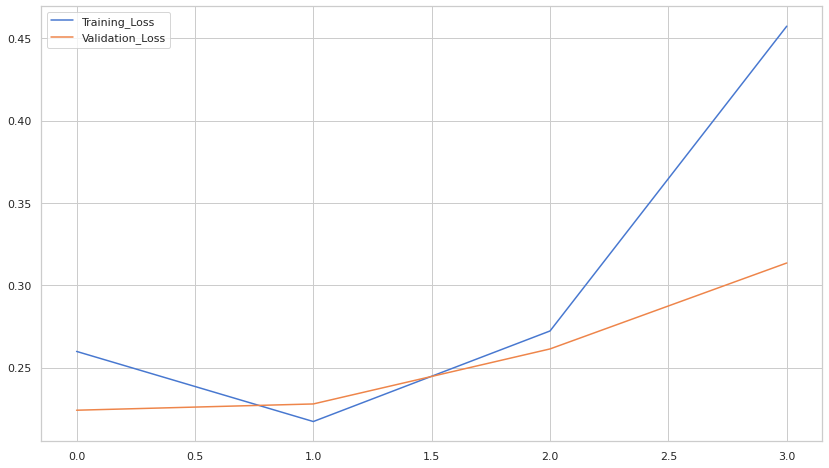

In [502]:
plt.plot(history.history['loss'], label = 'Training_Loss')
plt.plot(history.history['val_loss'], label = 'Validation_Loss')
plt.legend()

In [503]:
x_train_pred = AE.autoencoder_model.predict(x_train)

In [504]:
train_loss = pd.DataFrame(np.mean(np.abs(x_train_pred - x_train), axis = 1), columns = ['Error'])

In [505]:
train_loss

,Error
0,1.451684
1,1.452905
2,1.454037
3,1.455029
4,1.455838
...,...
4344,0.599032
4345,0.602378
4346,0.605262
4347,0.606811


In [458]:
AE.autoencoder_model.evaluate(x_test, y_test)

39/39 [==============================] - 1s 17ms/step - loss: 1.1234


1.123374581336975

## Distribution of errors

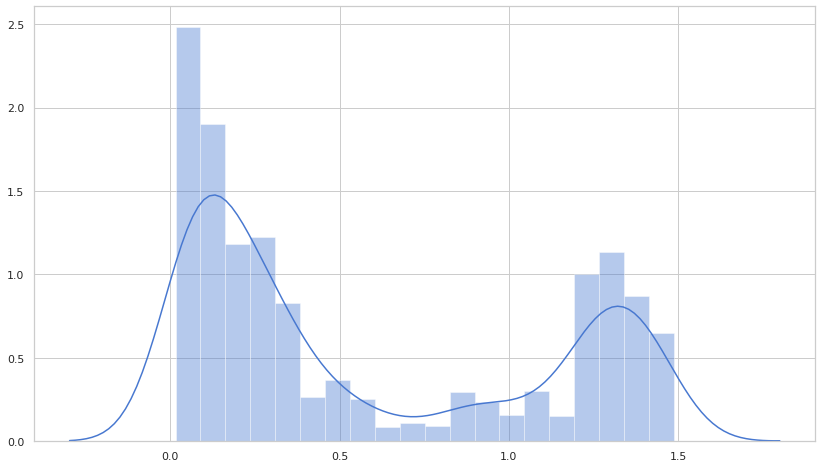

In [506]:
sns.distplot(train_loss, bins = 20, kde = True)

## Building Anomaly detection

Here we build an anomaly detector based on the reconstruciton error of the autoencoder

In [507]:
def anomaly_detector(model, threshold, x_test, test, window, col = 'Close'):
    x_test_pred = model.predict(x_test)
    reconst_err = np.mean(np.abs(x_test_pred - x_test), axis = 1)
    anomaly_score = pd.DataFrame(test[window:])
    anomaly_score[col] = test[col]
    anomaly_score['reconst_error'] = reconst_err
    anomaly_score['threshold'] = threshold
#     anomaly_score['threshold'] = threshold
    anomaly_score['anomaly'] = anomaly_score['reconst_error'] > anomaly_score['threshold']
    anomalies = anomaly_score[anomaly_score['anomaly'] == True]
    return anomaly_score, anomalies

In [508]:
window = 32
df_score, anomalies = anomaly_detector(AE.autoencoder_model, 0.9, x_test, test, window)

In [509]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[window:].index, y = df_score['reconst_error'], mode = 'lines'))
fig.add_trace(go.Scatter(x = test[window:].index, y = df_score['threshold'], mode = 'lines'))
fig.update_layout(showlegend = True)
fig.show()

In [510]:

fig = go.Figure()
fig.add_trace(go.Scatter(x = test[window:].index, y = test[window:].Close, mode = 'lines', name = 'Close price'))
fig.add_trace(go.Scatter(x = anomalies.index, y = anomalies['Close'], mode = 'markers', name = 'Anomalies'))
fig.update_layout(showlegend = True)
fig.show()